In [1]:
import pandas as pd
import tensorflow as tf
import gpflow
from pymatgen.ext.matproj import MPRester
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import ElementProperty
from matminer.featurizers.structure.matrix import SineCoulombMatrix

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

import numpy as np
import matplotlib.pyplot as plt

api_key = 'vitvGcsFqw8QTTDZ5L'

### Getting some data

In [93]:
criteria = {"elements": {"$all": ["Li"]}}
properties = ["material_id", 'formula', 'spacegroup.symbol', 'cif', "formation_energy_per_atom"] 

with MPRester(api_key) as m:
    data = m.query(criteria=criteria,properties=properties)
    
data = pd.DataFrame(data)

  0%|          | 0/19480 [00:00<?, ?it/s]

In [94]:
data.to_csv('Li_materials.csv')
data.head(5)

,material_id,formula,spacegroup.symbol,cif,formation_energy_per_atom
0,mp-10173,{'Li': 1.0},P6_3/mmc,# generated using pymatgen\ndata_Li\n_symmetry...,0.002524
1,mp-1018134,{'Li': 1.0},R-3m,# generated using pymatgen\ndata_Li\n_symmetry...,0.000000
2,mp-567337,{'Li': 1.0},I-43d,# generated using pymatgen\ndata_Li\n_symmetry...,0.010352
3,mp-1063005,{'Li': 1.0},P6/mmm,# generated using pymatgen\ndata_Li\n_symmetry...,0.018578
4,mp-976411,{'Li': 1.0},P6_3/mmc,# generated using pymatgen\ndata_Li\n_symmetry...,0.002798


### What kind of descriptors should we use?

#### Let's start with a compositional descriptor

In [3]:
data = pd.read_csv('Li_materials.csv')

In [4]:
import ast
chemical_formulas = [''.join([key + str(int(val)) for key, val in ast.literal_eval(formula).items()]) for formula in data["formula"]]
data.insert(loc=2, column='chemical_formula', value=chemical_formulas)

In [6]:
data = StrToComposition().featurize_dataframe(data, "chemical_formula", ignore_errors=True)
featurizer = ElementProperty.from_preset(preset_name="magpie")
X = featurizer.featurize_dataframe(data, col_id="composition").iloc[:, 8:]

ElementProperty: 100%|██████████| 19480/19480 [00:43<00:00, 450.41it/s]


In [7]:
X = X.dropna(how='any', axis=1)
X.head(5)

,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,3.0,3.0,0.0,3.0,0.0,3.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,229.0,229.0,0.0,229.0,0.0,229.0
1,3.0,3.0,0.0,3.0,0.0,3.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,229.0,229.0,0.0,229.0,0.0,229.0
2,3.0,3.0,0.0,3.0,0.0,3.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,229.0,229.0,0.0,229.0,0.0,229.0
3,3.0,3.0,0.0,3.0,0.0,3.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,229.0,229.0,0.0,229.0,0.0,229.0
4,3.0,3.0,0.0,3.0,0.0,3.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,229.0,229.0,0.0,229.0,0.0,229.0


In [8]:
x_scaler = StandardScaler()
X = x_scaler.fit_transform(X.to_numpy())

In [9]:
y = data['formation_energy_per_atom']
y_scaler = StandardScaler()
y = y_scaler.fit_transform(y.to_numpy().reshape(-1, 1))

In [65]:
print(X.shape, y.shape)

(19480, 132) (19480, 1)


### lets train a rf model

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

rf = RandomForestRegressor(n_estimators=500,random_state = 128)
rf.fit(X_train,y_train)

D:\Anaconda3\envs\materials\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


KeyboardInterrupt: 

In [12]:
pred_test = y_scaler.inverse_transform(rf.predict(X_test).reshape(-1, 1))
y_test = y_scaler.inverse_transform(y_test.reshape(-1, 1))

NameError: name 'rf' is not defined

In [73]:
r2 = r2_score(y_test, pred_test)
mse = mean_squared_error(y_test, pred_test)
mae = mean_absolute_error(y_test, pred_test)
print(f'R^2: {r2:.3f} \n mse: {mse:.3f} eV/atom \n mae: {mae:.3f} eV/atom')

R^2: -3.199 
 mse: 4.202 eV 
 mae: 2.026 eV


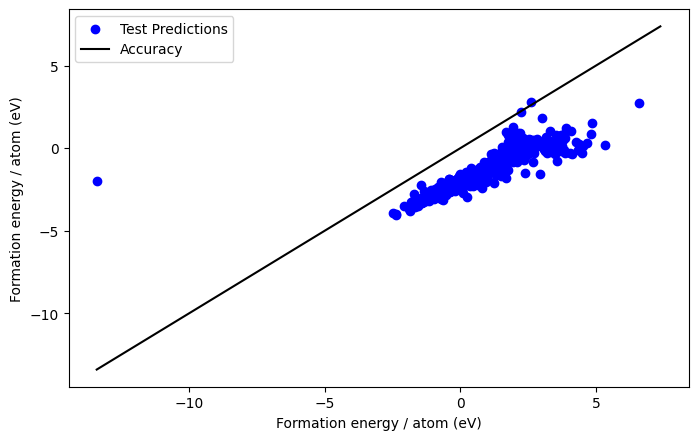

In [75]:
fig, ax = plt.subplots(figsize=[8,5],dpi=100)
ax.scatter(y_test, pred_test, color='blue',label='Test Predictions')
acc = np.linspace(min(y),max(y),1000)
ax.plot(acc,acc,color='k',label='Accuracy')
ax.set_xlabel('Formation energy / atom (eV)')
ax.set_ylabel('Formation energy / atom (eV)')
plt.legend()

### This works not that well, but it's not quite the 0.03 eV that is considered chemical accuracy

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [11]:
model = gpflow.models.GPR(data=(X_train, y_train), mean_function=gpflow.mean_functions.Constant(np.mean(y_train)), kernel=gpflow.kernels.RBF(), noise_variance=1)
optimizer = gpflow.optimizers.Scipy()
def closure():
    return -model.log_marginal_likelihood()
optimizer.minimize(closure, model.trainable_variables, options=dict(maxiter=10000))

ResourceExhaustedError:  OOM when allocating tensor with shape[15584,15584] and type double on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/eye/diag
 (defined at D:\Anaconda3\envs\materials\lib\site-packages\gpflow\optimizers\scipy.py:225)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference__tf_eval_555]

Errors may have originated from an input operation.
Input Source operations connected to node gradient_tape/eye/diag:
In[0] gradient_tape/eye/ones:	
In[1] gradient_tape/eye/diag/k:	
In[2] gradient_tape/eye/diag/num_rows:	
In[3] gradient_tape/eye/diag/num_cols:	
In[4] gradient_tape/eye/diag/padding_value:

Operation defined at: (most recent call last)
>>>   File "D:\Anaconda3\envs\materials\lib\runpy.py", line 193, in _run_module_as_main
>>>     "__main__", mod_spec)
>>> 
>>>   File "D:\Anaconda3\envs\materials\lib\runpy.py", line 85, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "D:\Anaconda3\envs\materials\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "D:\Anaconda3\envs\materials\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "D:\Anaconda3\envs\materials\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "D:\Anaconda3\envs\materials\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "D:\Anaconda3\envs\materials\lib\asyncio\base_events.py", line 541, in run_forever
>>>     self._run_once()
>>> 
>>>   File "D:\Anaconda3\envs\materials\lib\asyncio\base_events.py", line 1786, in _run_once
>>>     handle._run()
>>> 
>>>   File "D:\Anaconda3\envs\materials\lib\asyncio\events.py", line 88, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "D:\Anaconda3\envs\materials\lib\site-packages\ipykernel\kernelbase.py", line 461, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "D:\Anaconda3\envs\materials\lib\site-packages\ipykernel\kernelbase.py", line 450, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "D:\Anaconda3\envs\materials\lib\site-packages\ipykernel\kernelbase.py", line 357, in dispatch_shell
>>>     await result
>>> 
>>>   File "D:\Anaconda3\envs\materials\lib\site-packages\ipykernel\kernelbase.py", line 652, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "D:\Anaconda3\envs\materials\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "D:\Anaconda3\envs\materials\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "D:\Anaconda3\envs\materials\lib\site-packages\IPython\core\interactiveshell.py", line 2915, in run_cell
>>>     raw_cell, store_history, silent, shell_futures)
>>> 
>>>   File "D:\Anaconda3\envs\materials\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "D:\Anaconda3\envs\materials\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "D:\Anaconda3\envs\materials\lib\site-packages\IPython\core\interactiveshell.py", line 3186, in run_cell_async
>>>     interactivity=interactivity, compiler=compiler, result=result)
>>> 
>>>   File "D:\Anaconda3\envs\materials\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "D:\Anaconda3\envs\materials\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "C:\Users\rhjva\AppData\Local\Temp\ipykernel_27708\2416576693.py", line 5, in <module>
>>>     optimizer.minimize(closure, model.trainable_variables, options=dict(maxiter=10000))
>>> 
>>>   File "D:\Anaconda3\envs\materials\lib\site-packages\gpflow\optimizers\scipy.py", line 96, in minimize
>>>     func, initial_params, jac=True, method=method, **scipy_kwargs
>>> 
>>>   File "D:\Anaconda3\envs\materials\lib\site-packages\scipy\optimize\_minimize.py", line 624, in minimize
>>>     callback=callback, **options)
>>> 
>>>   File "D:\Anaconda3\envs\materials\lib\site-packages\scipy\optimize\lbfgsb.py", line 308, in _minimize_lbfgsb
>>>     finite_diff_rel_step=finite_diff_rel_step)
>>> 
>>>   File "D:\Anaconda3\envs\materials\lib\site-packages\scipy\optimize\optimize.py", line 262, in _prepare_scalar_function
>>>     finite_diff_rel_step, bounds, epsilon=epsilon)
>>> 
>>>   File "D:\Anaconda3\envs\materials\lib\site-packages\scipy\optimize\_differentiable_functions.py", line 140, in __init__
>>>     self._update_fun()
>>> 
>>>   File "D:\Anaconda3\envs\materials\lib\site-packages\scipy\optimize\_differentiable_functions.py", line 233, in _update_fun
>>>     self._update_fun_impl()
>>> 
>>>   File "D:\Anaconda3\envs\materials\lib\site-packages\scipy\optimize\_differentiable_functions.py", line 137, in update_fun
>>>     self.f = fun_wrapped(self.x)
>>> 
>>>   File "D:\Anaconda3\envs\materials\lib\site-packages\scipy\optimize\_differentiable_functions.py", line 134, in fun_wrapped
>>>     return fun(np.copy(x), *args)
>>> 
>>>   File "D:\Anaconda3\envs\materials\lib\site-packages\scipy\optimize\optimize.py", line 74, in __call__
>>>     self._compute_if_needed(x, *args)
>>> 
>>>   File "D:\Anaconda3\envs\materials\lib\site-packages\scipy\optimize\optimize.py", line 68, in _compute_if_needed
>>>     fg = self.fun(x, *args)
>>> 
>>>   File "D:\Anaconda3\envs\materials\lib\site-packages\gpflow\optimizers\scipy.py", line 137, in _eval
>>>     loss, grad = _tf_eval(tf.convert_to_tensor(x))
>>> 
>>>   File "D:\Anaconda3\envs\materials\lib\site-packages\gpflow\optimizers\scipy.py", line 119, in _tf_eval
>>>     if first_call:
>>> 
>>>   File "D:\Anaconda3\envs\materials\lib\site-packages\gpflow\optimizers\scipy.py", line 121, in _tf_eval
>>>     loss, grads = _compute_loss_and_gradients(
>>> 
>>>   File "D:\Anaconda3\envs\materials\lib\site-packages\gpflow\optimizers\scipy.py", line 225, in _compute_loss_and_gradients
>>>     grads = tape.gradient(loss, variables, unconnected_gradients=unconnected_gradients)
>>> 

In [ ]:
y_mean, y_var = model.predict_f(X_test)
pred_test = y_scaler.inverse_transform(y_mean)
y_test = y_scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
r2 = r2_score(y_test, pred_test)
mse = mean_squared_error(y_test, pred_test)
mae = mean_absolute_error(y_test, pred_test)
print(f'R^2: {r2:.3f} \n mse: {mse:.3f} eV/atom \n mae: {mae:.3f} eV/atom')

In [ ]:
fig, ax = plt.subplots(figsize=[8,5],dpi=100)
ax.scatter(y_test, pred_test, color='blue',label='Test Predictions')
acc = np.linspace(min(y),max(y),1000)
ax.plot(acc,acc,color='k',label='Accuracy')
ax.set_xlabel('Formation energy / atom (eV)')
ax.set_ylabel('Formation energy / atom (eV)')
plt.legend()

### lets now use some structural features as well

In [95]:
data = pd.read_csv('Li_materials.csv')

In [99]:
from pymatgen.io.cif import CifParser
structures = [CifParser.from_string(cif).get_structures()[0] for cif in data['cif']]

D:\Anaconda3\envs\materials\lib\site-packages\pymatgen\io\cif.py:1164: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


KeyboardInterrupt: 

In [79]:
featurizer = SineCoulombMatrix()
featurizer.fit(structures)
X = featurizer.featurize_dataframe(data, col_id="composition")
print(X.head(5))

NotFittedError: Please fit the SineCoulombMatrix before featurizing if using flatten=True.